In [2]:
import os
import keras
import keras.datasets.imdb as imdb

import h5py,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fidle
#import fidle.pwk as pwk

In [3]:
vocab_size = 10000 #On prend les 10000 token les plus frequents de mon dictionnaire
hide_most_frequently = 0

review_len = 256 #Taille de phrase de 256 token
dense_vector_size = 16

epochs    = 30
fit_verbosity        = 1
batch_size  = 512 #Nombre de token à prendre en compte avant de changer les paramètres du modèle

In [4]:
# ----- Retrieve x,y
#
start_char = 1      # Start of a sequence (padding is 0)
oov_char   = 2      # Out-of-vocabulary
index_from = 3      # First word id

(x_train, y_train), (x_test, y_test) = imdb.load_data( num_words  = vocab_size, 
                                                       skip_top   = hide_most_frequently,
                                                       start_char = start_char, 
                                                       oov_char   = oov_char, 
                                                       index_from = index_from)

# ---- About
#
print("Max(x_train,x_test)  : ", fidle.utils.rmax([x_train,x_test]) )
print("Min(x_train,x_test)  : ", fidle.utils.rmin([x_train,x_test]) )
print("(x_train)         : {}   y_train : {}".format(x_train.shape, y_train.shape))
print("(x_test)          : {}   y_test : {}".format(x_test.shape, y_test.shape))

Max(x_train,x_test)  :  9999
Min(x_train,x_test)  :  1
(x_train)         : (25000,)   y_train : (25000,)
(x_test)          : (25000,)   y_test : (25000,)


### Chargement du dictionnaire avec les mot pour pouvoir voir les phrases

In [5]:
# ---- Retrieve dictionary {word:index}, and encode it in ascii
#      Shift the dictionary from +3
#      Add <pad>, <start> and <unknown> tags
#      Create a reverse dictionary : {index:word}
#
word_index = imdb.get_word_index()
word_index = {w:(i+index_from) for w,i in word_index.items()}
word_index.update( {'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,} )
index_word = {index:word for word,index in word_index.items()} 

# ---- A nice function to transpose :
#
def dataset2text(review):
    return ' '.join([index_word.get(i, '?') for i in review])

### Padding

On vas mettre toutes les phrases à la même taille

In [6]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                     value   = 0,
                                                     padding = 'post',
                                                     maxlen  = review_len)

x_test  = keras.preprocessing.sequence.pad_sequences(x_test,
                                                     value   = 0 ,
                                                     padding = 'post',
                                                     maxlen  = review_len)

fidle.utils.subtitle('After padding :')
print(x_train[12])

<br>**After padding :**

[   1   13  119  954  189 1554   13   92  459   48    4  116    9 1492
 2291   42  726    4 1939  168 2031   13  423   14   20  549   18    4
    2  547   32    4   96   39    4  454    7    4   22    8    4   55
  130  168   13   92  359    6  158 1511    2   42    6 1913   19  194
 4455 4121    6  114    8   72   21  465 9667  304    4   51    9   14
   20   44  155    8    6  226  162  616  651   51    9   14   20   44
   10   10   14  218 4843  629   42 3017   21   48   25   28   35  534
    5    6  320    8  516    5   42   25  181    8  130   56  547 3571
    5 1471  851   14 2286    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

Pour la 12 ième phrase on voit que après le padding on a completer par des 0 pour atteindre la longueur 256

### Fabrication de modèle séquentielle

In [7]:
model = keras.Sequential(name='Embedding_model')

model.add(keras.layers.Input( shape=(review_len,) )) #Notre couche d'entré les phrases de longeur 256
model.add(keras.layers.Embedding( input_dim    = vocab_size,
                                  output_dim   = dense_vector_size)) #Nous ressort un vecteur de 'vocab_size' token où chaque token est représenté par un vecteur dense de taille 'dense_vector_size' obtenu par les couches d'enbeding

model.add(keras.layers.GlobalAveragePooling1D()) #Cette couche fait la moyenne ligne par ligne des composante des 'vocab_size' vecteur dense ce qui nous fait perdre l'odre des mots

model.add(keras.layers.Dense(dense_vector_size, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile( optimizer = 'adam',
               loss      = 'binary_crossentropy',
               metrics   = ['accuracy'])

model.summary()

Model: "Embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 256, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,289 (626.13 KB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

### Call back pour enregistré le meilleur modèle

In [8]:
os.makedirs('/models_embeding',   mode=0o750, exist_ok=True)
save_dir = '/models_embeding/best_model.keras'

savemodel_callback = keras.callbacks.ModelCheckpoint( filepath=save_dir, monitor='val_accuracy', mode='max', save_best_only=True)

### Entrainement du modèle

In [9]:
%%time

history = model.fit(x_train,
                    y_train,
                    epochs          = epochs,
                    batch_size      = batch_size,
                    validation_data = (x_test, y_test),
                    verbose         = fit_verbosity,
                    callbacks       = [savemodel_callback])

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5725 - loss: 0.6907 - val_accuracy: 0.7011 - val_loss: 0.6767
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7027 - loss: 0.6666 - val_accuracy: 0.6961 - val_loss: 0.6328
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7521 - loss: 0.6094 - val_accuracy: 0.7885 - val_loss: 0.5570
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8069 - loss: 0.5276 - val_accuracy: 0.8018 - val_loss: 0.4815
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8274 - loss: 0.4530 - val_accuracy: 0.8309 - val_loss: 0.4242
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8480 - loss: 0.3972 - val_accuracy: 0.8500 - val_loss: 0.3848
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8698 - loss: 0.3529 - val_accuracy: 0.8610 - val_loss: 0.3578
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8757 - loss: 0.3263 - val_accuracy: 0.8667 - 

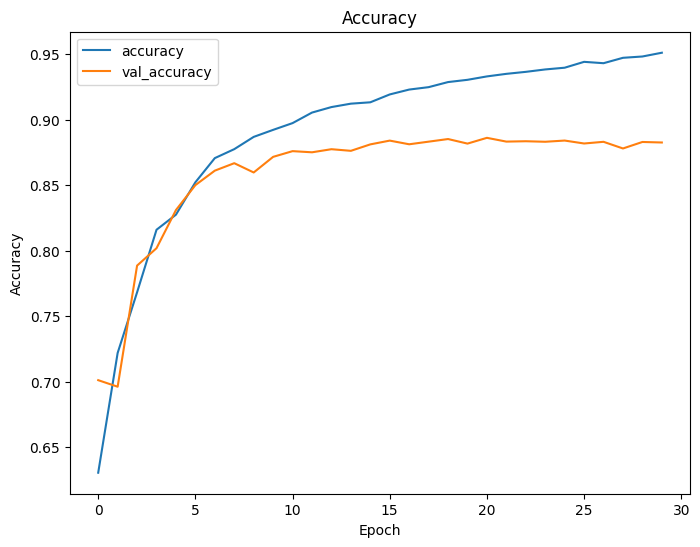

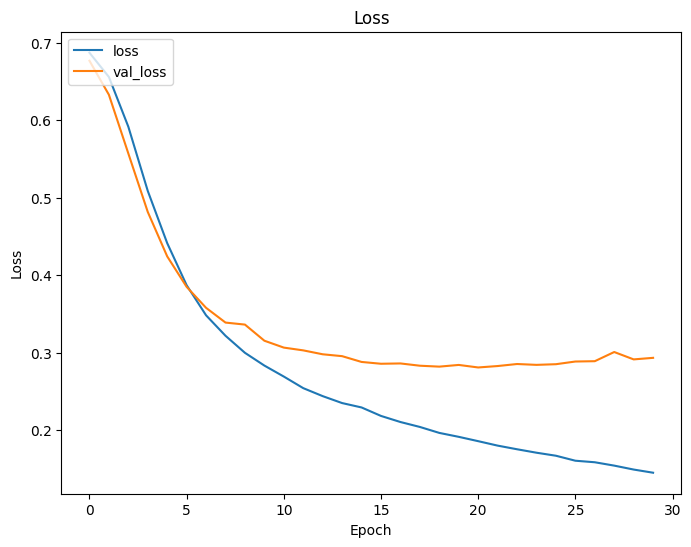

In [10]:
fidle.scrawler.history(history, save_as='02-history')

x_test / loss      : 0.2808
x_test / accuracy  : 0.8860


#### Accuracy donut is :

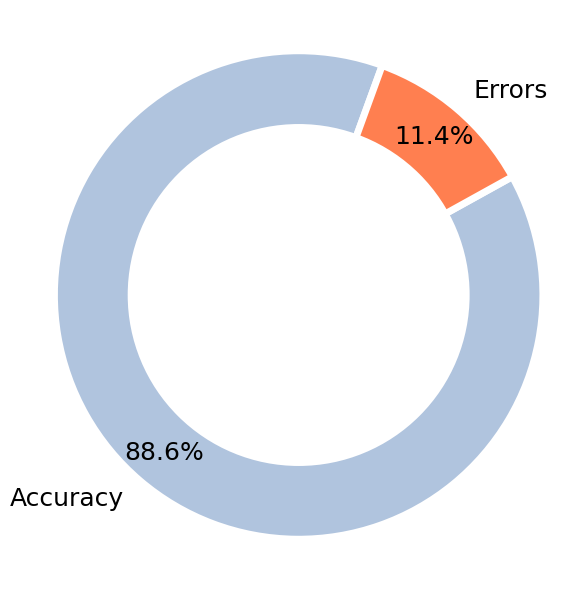

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


#### Confusion matrix is :

,0,1
0,0.89,0.11
1,0.11,0.89


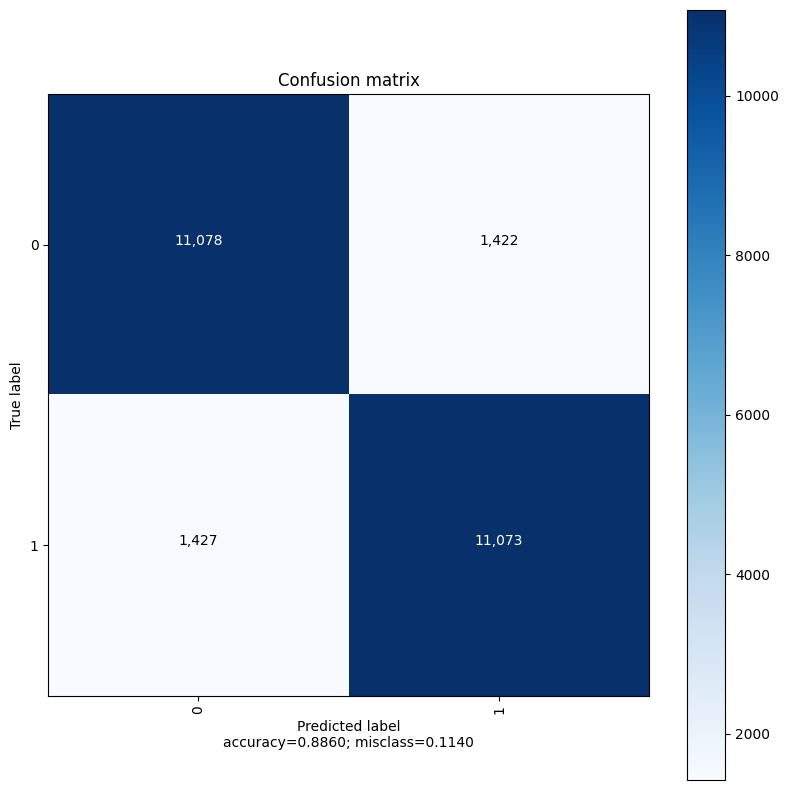

In [12]:
model = keras.models.load_model('/models_embeding/best_model.keras')

# ---- Evaluate
score  = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / accuracy  : {:5.4f}'.format(score[1]))

values=[score[1], 1-score[1]]
fidle.scrawler.donut(values,["Accuracy","Errors"], title="#### Accuracy donut is :", save_as='03-donut')

# ---- Confusion matrix

y_sigmoid = model.predict(x_test, verbose=fit_verbosity)

y_pred = y_sigmoid.copy()
y_pred[ y_sigmoid< 0.5 ] = 0
y_pred[ y_sigmoid>=0.5 ] = 1    

fidle.scrawler.confusion_matrix_txt(y_test,y_pred,labels=range(2))
fidle.scrawler.confusion_matrix(y_test,y_pred,range(2), figsize=(8, 8),normalize=False, save_as='04-confusion-matrix')